Capstone Project - The Battle of Neighborhoods (Week 2)

INTRODUCTION

As part of the final project, I have chosen to explore Indian restaurants in the city of New York.When anyone relocated to a new city or are just visiting, the first thing that anyone search for is their origin country food. 

New York City's demographics show that it is a large and ethnically diverse metropolis. With it's diverse culture , comes diverse food items. There are many resturants in New york City, each beloning to different categories like Chinese , Indian , French etc.This project will list and visualize all major parts of New York City that have good indian resturants.

PROBLEM STATEMENT

To find the following
1. List and visualize all major parts of New York City where Indian restaurants are rated good.
2. Which is the best location in New York City for Indian Cuisine?
3. Which areas have potential Indian Restaurant Market?
4. Which all areas have no Indian Restaurants?
5. Which is the best place to stay if you prefer Indian Cuisine?


DATA REQUIREMENT & COLLECTION

For this project we need the following data:
New York City data that contains list Boroughs, Neighbourhoods along with their latitude and longitude.

Data source : https://cocl.us/new_york_dataset

Description: This data set contains the required information. And we will use this data set to explore various neighbourhoods of New York City.


Indian restaurants in each neighbourhood of New York City.

Data source : Foursquare API

Description: By using this API we will get all the venues in each neighbourhood. We can filter these venues to get only Indian restaurants.


GeoSpace data
Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

Description: By using this geo space data we will get the New York Borough boundaries that will help us visualize choropleth map.


METHODOLOGY

1.Collect the New York city data from "https://cocl.us/new_york_dataset".

2.Find all venues for each neighborhood using FourSquare API.

3.Filter out all Indian Restuarant venues.

4.Use FourSquare API to find various details like Ratings, Tips, and Like count for all the Indian Resturants.

5.Sort the data using Ratings.

6.Visualize the Ranking of neighborhoods using python's Folium library to find answers for the problem statement.

LIMITATIONS

As a final note, all of the above analysis is depended on the adequacy and accuracy of Four Square data.

WORKINGS

Lets Start by importing the required Libraries

In [73]:
import sys
!{sys.executable} -m pip install geocoder
!{sys.executable} -m pip install folium

print('Packages installed.')

Packages installed.Requirement already satisfied: numpy in c:\users\ernxvsh\anaconda3\lib\site-packages (from folium) (1.18.5)



In [74]:
pip install BeautifulSoup4

Note: you may need to restart the kernel to use updated packages.


In [75]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests

from bs4 import BeautifulSoup
#!pip install geocoder
import geocoder
import os
#!pip install folium
import folium # map rendering library
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')


Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


In [76]:
#Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [77]:
CLIENT_ID = 'C1U4FMLWLBBH1QIGGPHZR1BLABZURFIRIHSSBFA2YCUWHKUC' # your Foursquare ID
CLIENT_SECRET = 'A0GFN2ZSUTITCWSUCO2PWJYTXPZFP1THM0HQ1YMUJCJSHCRG' # your Foursquare Secret
VERSION = '20180605'

In [94]:
#We define a function to interact with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

def get_venues(lat,lng):
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID =  'C1U4FMLWLBBH1QIGGPHZR1BLABZURFIRIHSSBFA2YCUWHKUC'
    CLIENT_SECRET = 'A0GFN2ZSUTITCWSUCO2PWJYTXPZFP1THM0HQ1YMUJCJSHCRG'
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    
    results = requests.get(url).json()
    jsonBlob = requests.get(url, "none").json()
    if 'response' not in jsonBlob or 'groups' not in jsonBlob['response']:
        return False
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
   
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)

    return df


In [95]:
#Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking. 
def get_venue_details(venue_id):
        
    CLIENT_ID = 'C1U4FMLWLBBH1QIGGPHZR1BLABZURFIRIHSSBFA2YCUWHKUC'# your Foursquare ID
    CLIENT_SECRET = 'A0GFN2ZSUTITCWSUCO2PWJYTXPZFP1THM0HQ1YMUJCJSHCRG' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
        venue_id)
    
    # get all the data
    results =  requests.get(url).json()
    jsonBlob = requests.get(url, "none").json()
    if 'response' not in jsonBlob or 'groups' not in jsonBlob['response']:
        return False
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


In [96]:
#Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [97]:
#We will call the above funtion to get the new york city data.
new_york_data=get_new_york_data()

In [98]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [99]:
new_york_data.shape

(306, 4)

The above result shows that there are 306 different Neighborhoods in New York

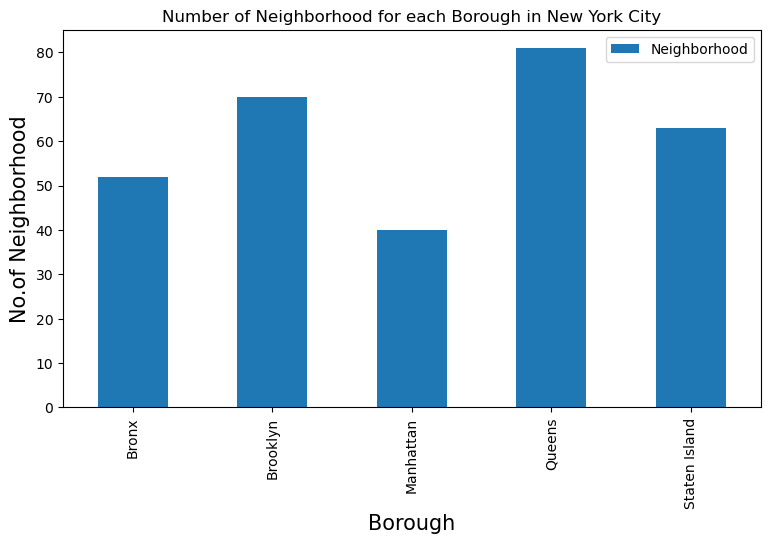

In [100]:
#Now let create a BAR PLOT to show different Neighborhoods in New York.
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

From chart we can conclude that Queens has highest number of neighborhoods

In [101]:
#Next we will collect Indian resturants for each Neighborhood
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1

for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0


TypeError: 'bool' object is not subscriptable

In [ ]:
indian_rest_ny.head()

In [ ]:
indian_rest_ny.shape

From the above analysis, we can conclude that there are 151 Indian Resturants across New York City

In [ ]:
#Now let create a BAR PLOT to show Number of Indian Resturants for each Borough in New York City
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

From the above Bar Plot, we can conclude that Queens has highest number of Indian resturants

In [ ]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [ ]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

We can conclude that, Floral Park in Queens has the highest number of Indian Resturants with a total count of 11

In [ ]:
#Now we will get the ranking of each resturant for further analysis
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

In [ ]:
indian_rest_stats_ny.head()

In [38]:
indian_rest_stats_ny.shape

(0, 7)

In [56]:
indian_rest_ny.shape

(151, 4)

In [57]:
#Now that we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required.
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [58]:
#Lets verify the data from saved csv file.
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')
indian_rest_stats_ny_csv.shape

(151, 7)

In [59]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,0,0,0,0,0
1,Bronx,Parkchester,0,0,0,0,0
2,Bronx,Spuyten Duyvil,0,0,0,0,0
3,Bronx,Concourse,0,0,0,0,0
4,Bronx,Unionport,0,0,0,0,0


In [49]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Borough       151 non-null    object
 1   Neighborhood  151 non-null    object
 2   ID            151 non-null    object
 3   Name          151 non-null    object
 4   Likes         151 non-null    object
 5   Rating        151 non-null    object
 6   Tips          151 non-null    object
dtypes: object(7)
memory usage: 8.4+ KB


In [60]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

TypeError: reduction operation 'argmax' not allowed for this dtype

In [72]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

TypeError: reduction operation 'argmax' not allowed for this dtype

In [73]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

TypeError: reduction operation 'argmax' not allowed for this dtype

In [74]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

DataError: No numeric types to aggregate

In [75]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

NameError: name 'ny_neighborhood_stats' is not defined

In [76]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

DataError: No numeric types to aggregate

In [77]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

NameError: name 'ny_borough_stats' is not defined

DataError: No numeric types to aggregate

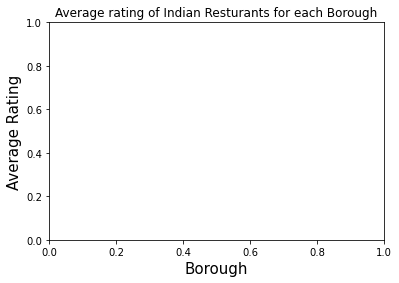

In [78]:
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [ ]:
#We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map.
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [79]:
ny_neighborhood_stats

NameError: name 'ny_neighborhood_stats' is not defined

In [80]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

NameError: name 'ny_neighborhood_stats' is not defined

In [81]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

NameError: name 'ny_neighborhood_stats' is not defined

In [82]:
ny_neighborhood_stats

NameError: name 'ny_neighborhood_stats' is not defined

In [83]:
#Lets plot on map
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [84]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

NameError: name 'ny_neighborhood_stats' is not defined

In [85]:
#Lets add a new field to dataframe for labeling purpose.

In [86]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

NameError: name 'ny_neighborhood_stats' is not defined

In [87]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

NameError: name 'ny_neighborhood_stats' is not defined

In [88]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough_Boundaries.geojson'

map = ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

NameError: name 'ny_borough_stats' is not defined

CONCLUSION
Following conclusion can be drawn basis the above analysis
1.Astoria(Queens), Blissville(Queens), Civic Center(Manhattan) are some of the best neighborhoods for Indian cuisine.

2.Manhattan have potential Indian Resturant Market.

3.Staten Island ranks last in average rating of Indian Resturants.

4.Manhattan is the best place to stay if you prefer Indian Cuisine.